### 이진 분류를 위한 로지스틱 회귀

In [2]:
# 유방암 데이터 세트 준비
# 1. load_breast_cancer()함수 호출하기
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [16]:
type(cancer) # Bunch클래스 객체

sklearn.utils.Bunch

In [3]:
# 2. 입력 데이터 확인하기
print(cancer.data.shape, cancer.target.shape)

(569, 30) (569,)


cancer에는 569개의 샘플과 30개의 특성이 있음.

In [4]:
# 처음 3개 샘플 출력
cancer.data[:3]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

특성 데이터를 살펴보면, 실수 범위의 값이고 양수로 이루어져 있음.    

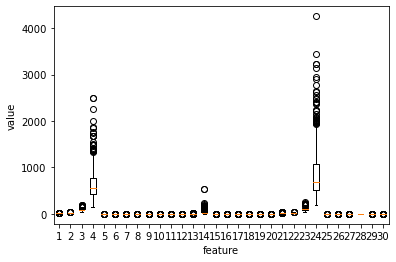

In [7]:
# 3. 박스 플롯으로 특성의 사분위 관찰하기
import matplotlib.pyplot as plt
import numpy as np

plt.boxplot(cancer.data)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

4, 14, 24번째 특성이 다른 특성보다 값의 분포가 훨씬 큼. 4,14,24번째 특성의 인덱스를 리스트로 묶어 확인.

In [9]:
# 4. 눈에 띄는 특성 살펴보기
cancer.feature_names[[3,13,23]]

array(['mean area', 'area error', 'worst area'], dtype='<U23')

In [18]:
# 5. 타깃 데이터 확인하기
np.unique(cancer.target, return_counts=True) # return_counts 매개변수를 True로 지정하면 고유한 값이 등장한 횟수 반환.

(array([0, 1]), array([212, 357]))

0은 음성클래스, 1은 양성클래스.    
212개의 음성클래스(정상종양), 357개의 양성클래스(악성종양)

In [19]:
# 6. 훈련데이터 세트 저장하기.
x = cancer.data
y = cancer.target

In [20]:
# 7. train_test_split()함수로 훈련 데이터 세트 나누기

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

- stratify = y    
 stratify 는 훈련데이터를 나눌때 클래스 비율을 동일하게 만듦. 데이터를 나누기 전에 일부 클래스 비율이 불균형한 경우 stratify를 y로 지정해야함.    
- test_size = 0.2     
 입력된 데이터 세트의 20%를 테스트 세트로 나눔    
- random_state = 42
 

In [21]:
# 8. 결과 확인
print(x_train.shape, x_test.shape)

(455, 30) (114, 30)


In [22]:
# 9. unique()함수로 훈련 세트의 타깃 확인하기
np.unique(y_train, return_counts=True)

(array([0, 1]), array([170, 285]))

In [23]:
# 로지스틱 회귀 구현하기

class LogisticNeuron:
    
    def __init__(self):
        self.w = None
        self.b = None
        
    def forpass(self, x):
        z = np.sum(x*self.w) + self.b      # 직선 방정식 계산
        return z
    
    def backprop(self, x, err):
        w_grad = x*err                # 가중치에 대한 그레이디언트를 계산
        b_grad = 1*err                # 절편에 대한 그레이디언트를 계산
        return w_grad, b_grad

#### __init()__ 메서드는 가중치와 절편을 미리 초기화하지 않음. 
입력 데이터의 특성이 많아 가중치를 미리 초기화 하지 않음. 가중치는 나중에 입력데이터를 보고 특성개수에 맞게 결정.

#### forpass() 메서드에 넘파이 함수 사용.
가중치와 입력 특성의 곱을 모두 더하기 위해 np.sum()함수 사용.

In [24]:
# 훈련 메서드 구현하기

# 1. fit()메서드 구현하기

def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])     # 가중치를 초기화
    self.b = 0                       # 절편 초기화
    for i in range(epochs):          # epochs만큼 반복    
        for x_i, y_i in zip(x,y):    # 모든 샘플에 대해 반복
            z = self.forpass(x_i)    # 정방향 계산
            a = self.activation(z)   # 활성화함수 적용
            err = -(y_i - a)         # 오차 계산
            w_grad, b_grad = self.backprop(x_i,err)  # 역방향 계산
            self.w -= w_grad        # 가중치 업데이트
            self.b -= b_grad        # 절편 업데이트
            
            
# 2. activation() 메서드 구현하기

def activation(self, z):
    a = 1/(1+np.exp(-z))       # 시그모이드 계산
    return a
        

In [25]:
# 예측하는 메서드 구현하기

# 1. predict() 메서드 구현하기

def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]  # 선형함수 적용
    a = self.activation(np.array(z))      # 활성화 함수 적용
    return a > 0.5                        # 계단 함수 적용

In [26]:
# 구현 내용 한눈에

class LogisticNeuron:
    
    def __init__(self):
        self.w = None
        self.b = None
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self,x,err):
        w_grad = x*err
        b_grad = 1*err
        return w_grad, b_grad
    
    def activation(self, z):
        a = 1/(1+np.exp(-z))
        return a
    
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        for i in range(epochs):
            for x_i, y_i in zip(x,y):
                z = self.forpass(x_i)
                a = self.activation(z)
                err = -(y_i -a)
                w_grad, b_grad = self.backprop(x_i,err)
                self.w -= w_grad
                self.b -= b_grad
                
    def predict(self,x):
        z = [self.forpass(x_i) for x_i in x]
        a = self.activation(np.array(z))
        return a >0.5

In [27]:
# 로지스틱 회귀 모델 훈련시키기
# 1. 모델 훈련하기
neuron = LogisticNeuron()
neuron.fit(x_train,y_train)

# 2. 테스트 세트 사용해 모델의 정확도 평가하기
np.mean(neuron.predict(x_test)==y_test)

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


0.8245614035087719

predict() 메서드 반환값은 True나 False로 채워진 (m,)크기의 배열이고, y_test는 0또는 1로 채워진 (m,)크기의 배열이므로 바로 비교 가능.    
np.mean()함수는 매개변수 값으로 전달한 비교문 결과(넘파이배열)의 평균 계산.    
계산 결과 0.82는 올바르게 예측한 샘플의 비율이 됨. == 정확도

## 로지스틱 회귀 뉴런으로 단일층 신경망 만들기

In [28]:
# 손실함수의 결과값 저정기능추가
# 매 에포크마다 훈련 세트의 샘플 순서 섞어 사용하기
# score()메서드 추가


class SingleLayer:
    
    def __init__(self):
        self.w = None
        self.b = None
        self.losses = []
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self, x, err):
        w_grad = x *err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def activation(self,z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i],err)
                self.w -= w_grad
                self.b -= b_grad
                a = np.clip(a, 1e-10, 1-1e-10)
                
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y))
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [30]:
# 단일층 신경망 훈련하기
# 1. 단일층 신경망 훈련하고 정확도 출력하기

layer = SingleLayer()
layer.fit(x_train, y_train)
layer.score(x_test, y_test)

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


0.9473684210526315

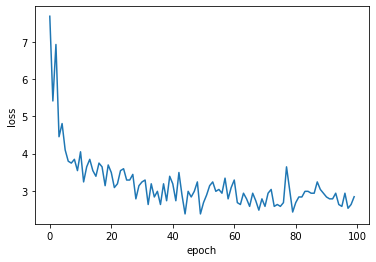

In [31]:
# 2. 손실 함수 누적값 확인하기.

plt.plot(layer.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 사이킷런으로 로지스틱 회귀를 수행

In [33]:
from sklearn.linear_model import SGDClassifier

# 1.로지스틱 손실함수 지정하기
sgd = SGDClassifier(loss='log',max_iter=100,tol=1e-3,random_state=42)

# 2.사이킷런으로 훈련하고 평가하기
sgd.fit(x_train, y_train)
sgd.score(x_test,y_test)

0.8333333333333334

In [34]:
# 사이킷런으로 예측하기
sgd.predict(x_test[0:10])

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])